# **Détection des Fake news avec BerConvoNet**</p>

## Réalisé par : Chaymaa Ari
## Encadré par : Prof Nachaoui Mourad



 ## 1.     Importation des bibliothèque :





In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
import string
import re
#Visualization Libs
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


 ## 2. Lire le fichier Csv :

In [2]:
df = pd.read_csv('/content/fake_or_real_news.csv')

 ## 3.EDA :

In [12]:
df.shape

(6335, 4)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


In [15]:
df.describe()

Unnamed: 0
count   6335.000000
mean    5280.415627
std     3038.503953
min        2.000000
25%     2674.500000
50%     5271.000000
75%     7901.000000
max    10557.000000

In [16]:
df

Unnamed: 0                                              title  \
0           8476                       You Can Smell Hillary’s Fear   
1          10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2           3608        Kerry to go to Paris in gesture of sympathy   
3          10142  Bernie supporters on Twitter erupt in anger ag...   
4            875   The Battle of New York: Why This Primary Matters   
...          ...                                                ...   
6330        4490  State Department says it can't find emails fro...   
6331        8062  The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...   
6332        8622  Anti-Trump Protesters Are Tools of the Oligarc...   
6333        4021  In Ethiopia, Obama seeks progress on peace, se...   
6334        4330  Jeb Bush Is Suddenly Attacking Trump. Here's W...   

                                                   text label  
0     Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1     Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2     U.S. Secretary of State John F. Kerry said Mon...  REAL  
3     — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
4     It's primary day in New York and front-runners...  REAL  
...                                                 ...   ...  
6330  The State Department told the Republican Natio...  REAL  
6331  The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...  FAKE  
6332   Anti-Trump Protesters Are Tools of the Oligar...  FAKE  
6333  ADDIS ABABA, Ethiopia —President Obama convene...  REAL  
6334  Jeb Bush Is Suddenly Attacking Trump. Here's W...  REAL  

[6335 rows x 4 columns]

In [17]:
#Selecting Specific Columns in a DataFrame
df1 = df[['title','text','label']]
#Calculating the Number of Missing Values
null_df = df1.isnull().sum().sort_values(ascending = False)
#Calculating the Percentage of Missing Values
percent = (df1.isnull().sum() / df1.isnull().count()).sort_values(ascending = False) * 100
#Combining Counts and Percentages into a Single DataFrame:
null_df = pd.concat([null_df, percent], axis = 1, keys = ['Counts', '% Missing'])

null_df.head()

Counts  % Missing
title       0        0.0
text        0        0.0
label       0        0.0

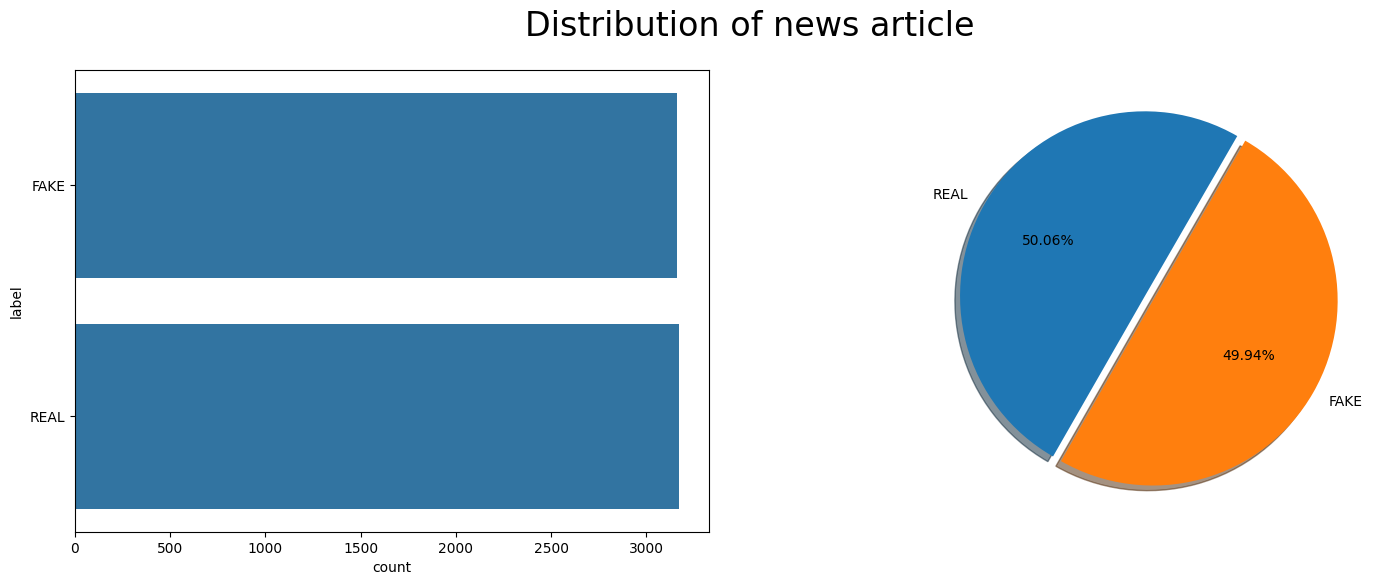

In [18]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sns.countplot(df['label'], ax=axes[0])
axes[1].pie(df['label'].value_counts(),
            labels=['REAL', 'FAKE'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of news article', fontsize=24)
plt.show()

In [7]:
#Assigning Binary Labels
df['label'] = df['label'].replace({'FAKE': 0, 'REAL': 1})
#Supprimer les lignes dupliqué
df = df.drop_duplicates()

In [20]:
df

Unnamed: 0                                              title  \
0           8476                       You Can Smell Hillary’s Fear   
1          10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2           3608        Kerry to go to Paris in gesture of sympathy   
3          10142  Bernie supporters on Twitter erupt in anger ag...   
4            875   The Battle of New York: Why This Primary Matters   
...          ...                                                ...   
6330        4490  State Department says it can't find emails fro...   
6331        8062  The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...   
6332        8622  Anti-Trump Protesters Are Tools of the Oligarc...   
6333        4021  In Ethiopia, Obama seeks progress on peace, se...   
6334        4330  Jeb Bush Is Suddenly Attacking Trump. Here's W...   

                                                   text  label  
0     Daniel Greenfield, a Shillman Journalism Fello...      0  
1     Google Pinterest Digg Linkedin Reddit Stumbleu...      0  
2     U.S. Secretary of State John F. Kerry said Mon...      1  
3     — Kaydee King (@KaydeeKing) November 9, 2016 T...      0  
4     It's primary day in New York and front-runners...      1  
...                                                 ...    ...  
6330  The State Department told the Republican Natio...      1  
6331  The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...      0  
6332   Anti-Trump Protesters Are Tools of the Oligar...      0  
6333  ADDIS ABABA, Ethiopia —President Obama convene...      1  
6334  Jeb Bush Is Suddenly Attacking Trump. Here's W...      1  

[6335 rows x 4 columns]

In [21]:
# Download and prepare data
nltk.download('stopwords')

# Set of English stopwords
stop = set(stopwords.words('english'))
stop.update(string.punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [22]:
#nettoyer une chaîne de caractères, en particulier du texte récupéré à partir du HTML, en le débarrassant de divers éléments indésirables
def denoise_text(text):
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    text = re.sub(r'\[[^]]*\]', '', text)
    text = re.sub(r'http\S+', '', text)
    return " ".join([word.strip() for word in text.split() if word.strip().lower() not in stop])

In [23]:
#appliquer la fonction denoise sur la colone text de notre dataframe
df['text'] = df['text'].apply(denoise_text)

<ipython-input-22-39ee1b023d20>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


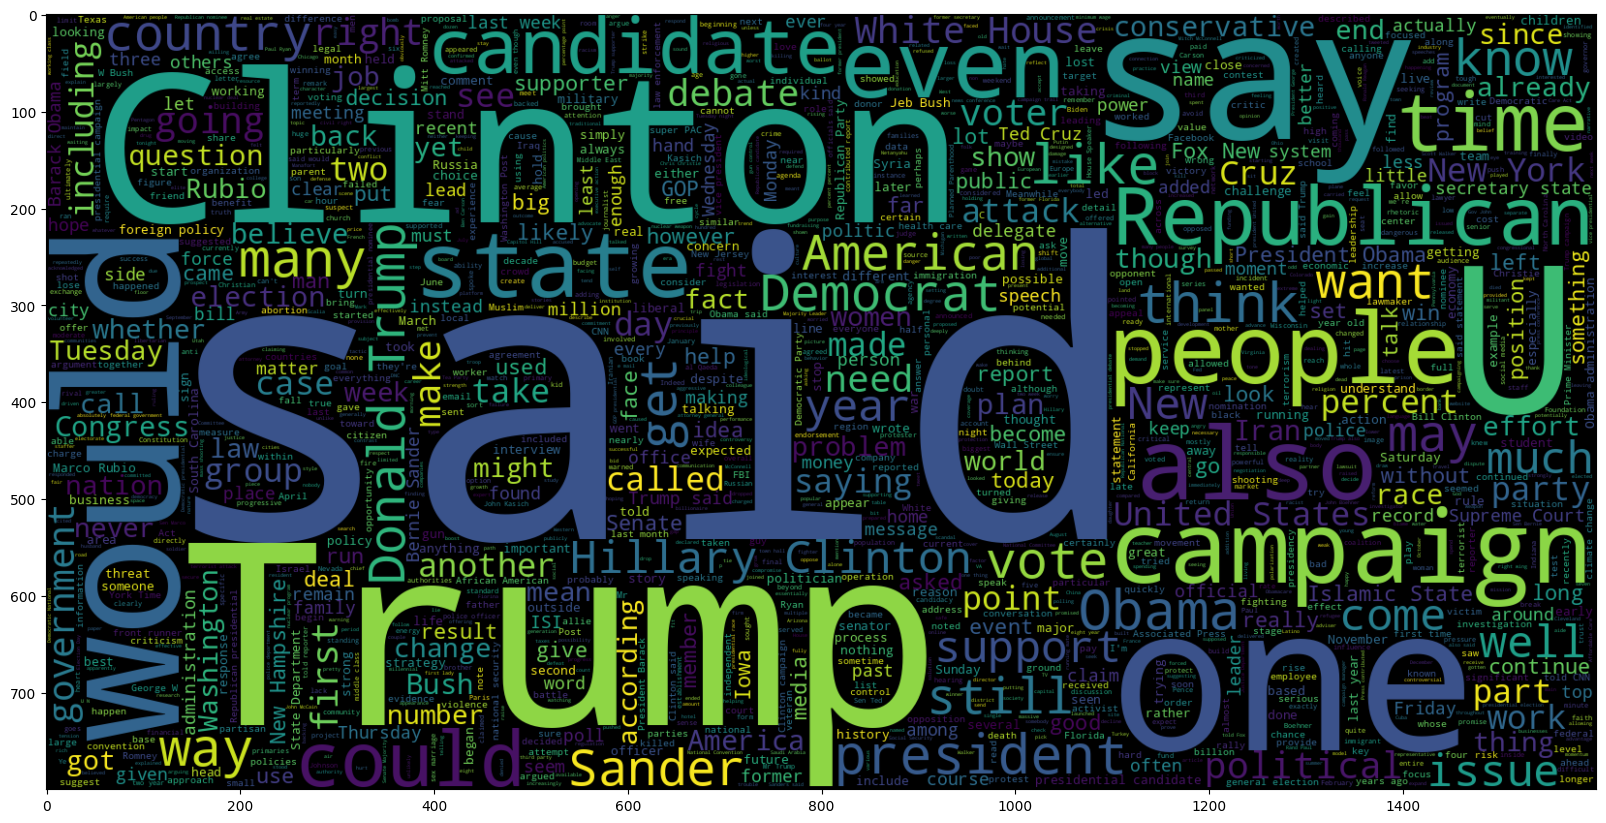

In [24]:
# word clouds for true news
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800, stopwords = stop).generate(" ".join(df[df.label == 1].text))
plt.imshow(wc, interpolation = 'bilinear')
# show the most prominent or frequent words in a body of true news


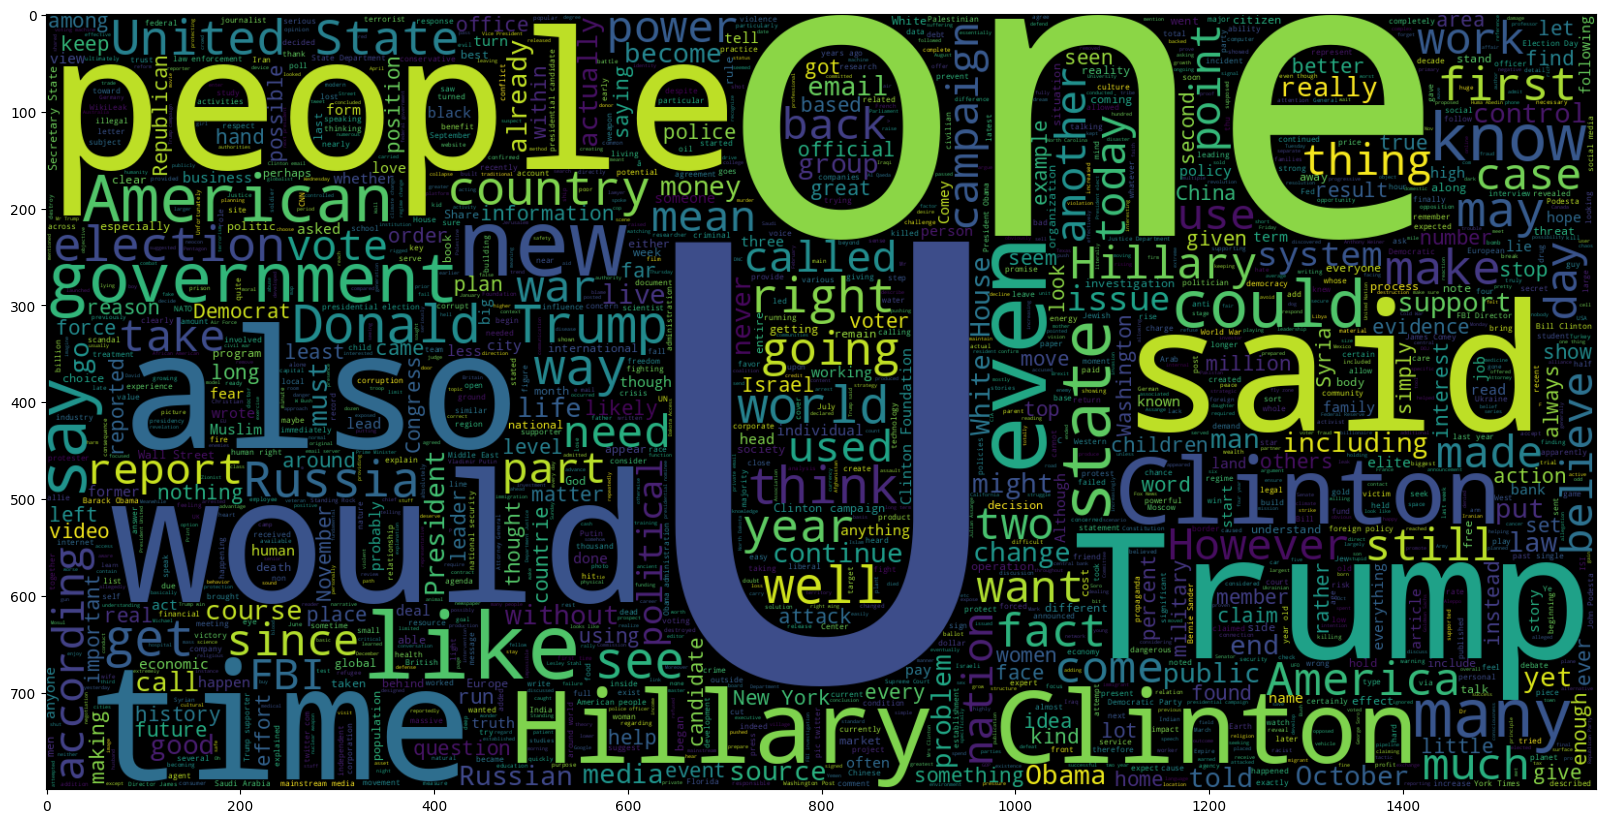

In [25]:
# word clouds for fake news
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800, stopwords = stop).generate(" ".join(df[df.label == 0].text))
plt.imshow(wc, interpolation = 'bilinear')

[nltk_data] Downloading package wordnet to /root/nltk_data...


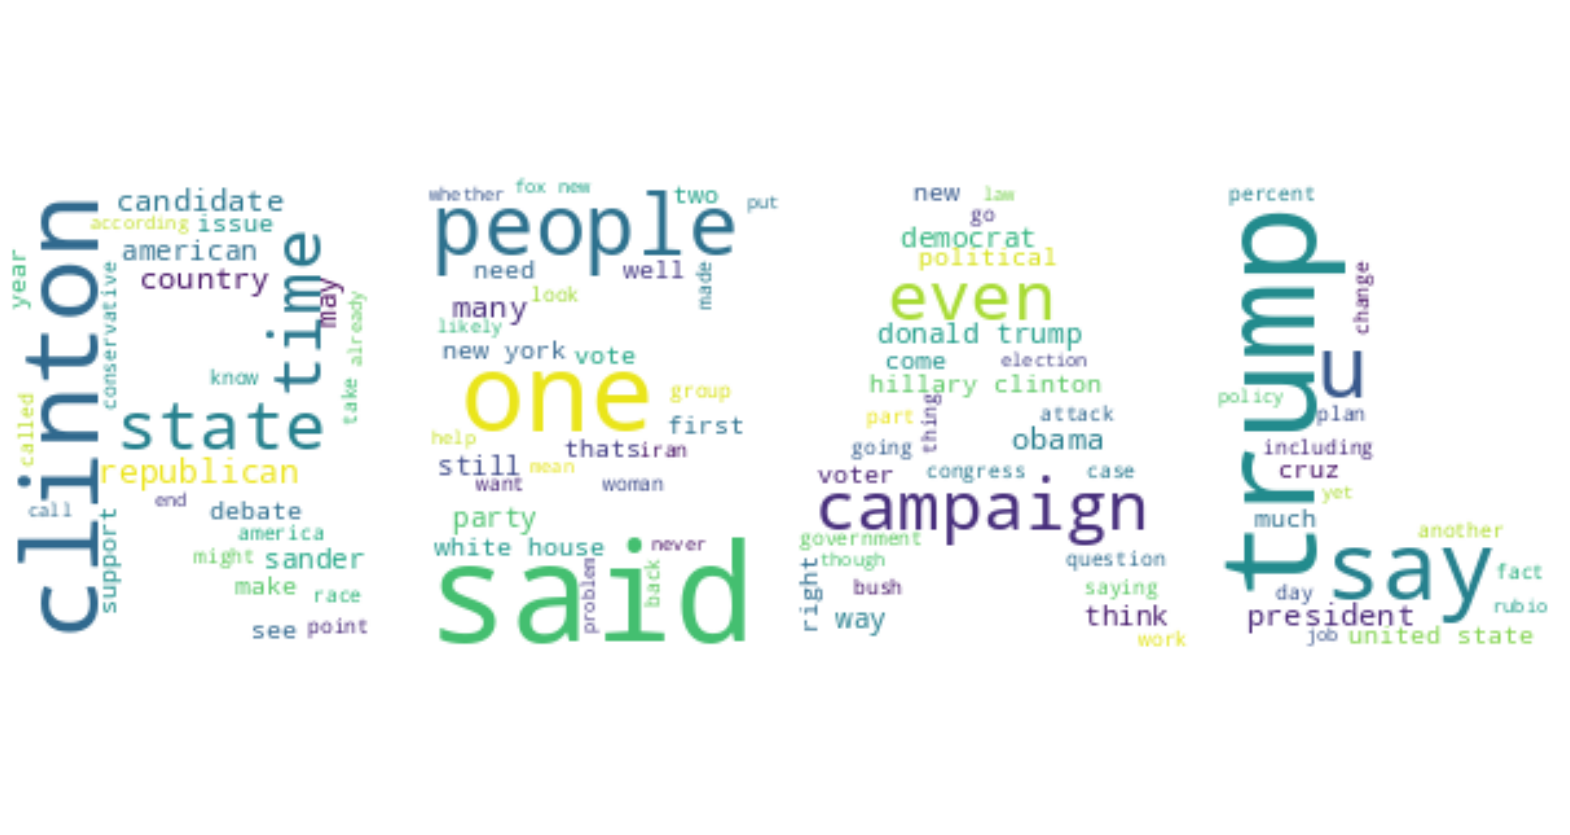

<Figure size 640x480 with 0 Axes>

In [26]:
# WordNet is a large lexical database of English
nltk.download('wordnet')
# sets up a matplotlib figure with a specified size
plt.figure(figsize = (20,20))

def clean(text: str) -> list:
  'A simple function to cleanup text data'
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  # Encodes the text to ASCII, ignoring non-ASCII characters, and decodes it back to UTF-8
  text = (text.encode('ascii', 'ignore')
           .decode('utf-8', 'ignore')
           .lower())
  # Removes punctuation
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

corpus = clean(' '.join(df[df.label == 1].text))

#converts a list of words back into a single string
def listToString(s):
  str1 = " "
  return (str1.join(s))

corpus_str = listToString(corpus)
#d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
def transform_format(val):
  if val.any() == 0:
    return 255
  else:
    return val

# Loads an image file, which is then converted to a NumPy array
coloring = np.array(Image.open("/content/REAL_Word_Mark_Green_Logo.jpg"))

stoplist = set(STOPWORDS)
# Create a WordCloud object
wc = WordCloud(background_color = "white", max_words = 2000, width = 1600, height = 800,mask = coloring, stopwords = stoplist, max_font_size = 100)

# Generates the word cloud from corpus_str
wc.generate(corpus_str)

image_colors = ImageColorGenerator(coloring)
plt.imshow(wc, interpolation = 'bilinear')
plt.axis("off")

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig("real_new_word_cloud.png", bbox_inches = 'tight', dpi = 600)



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


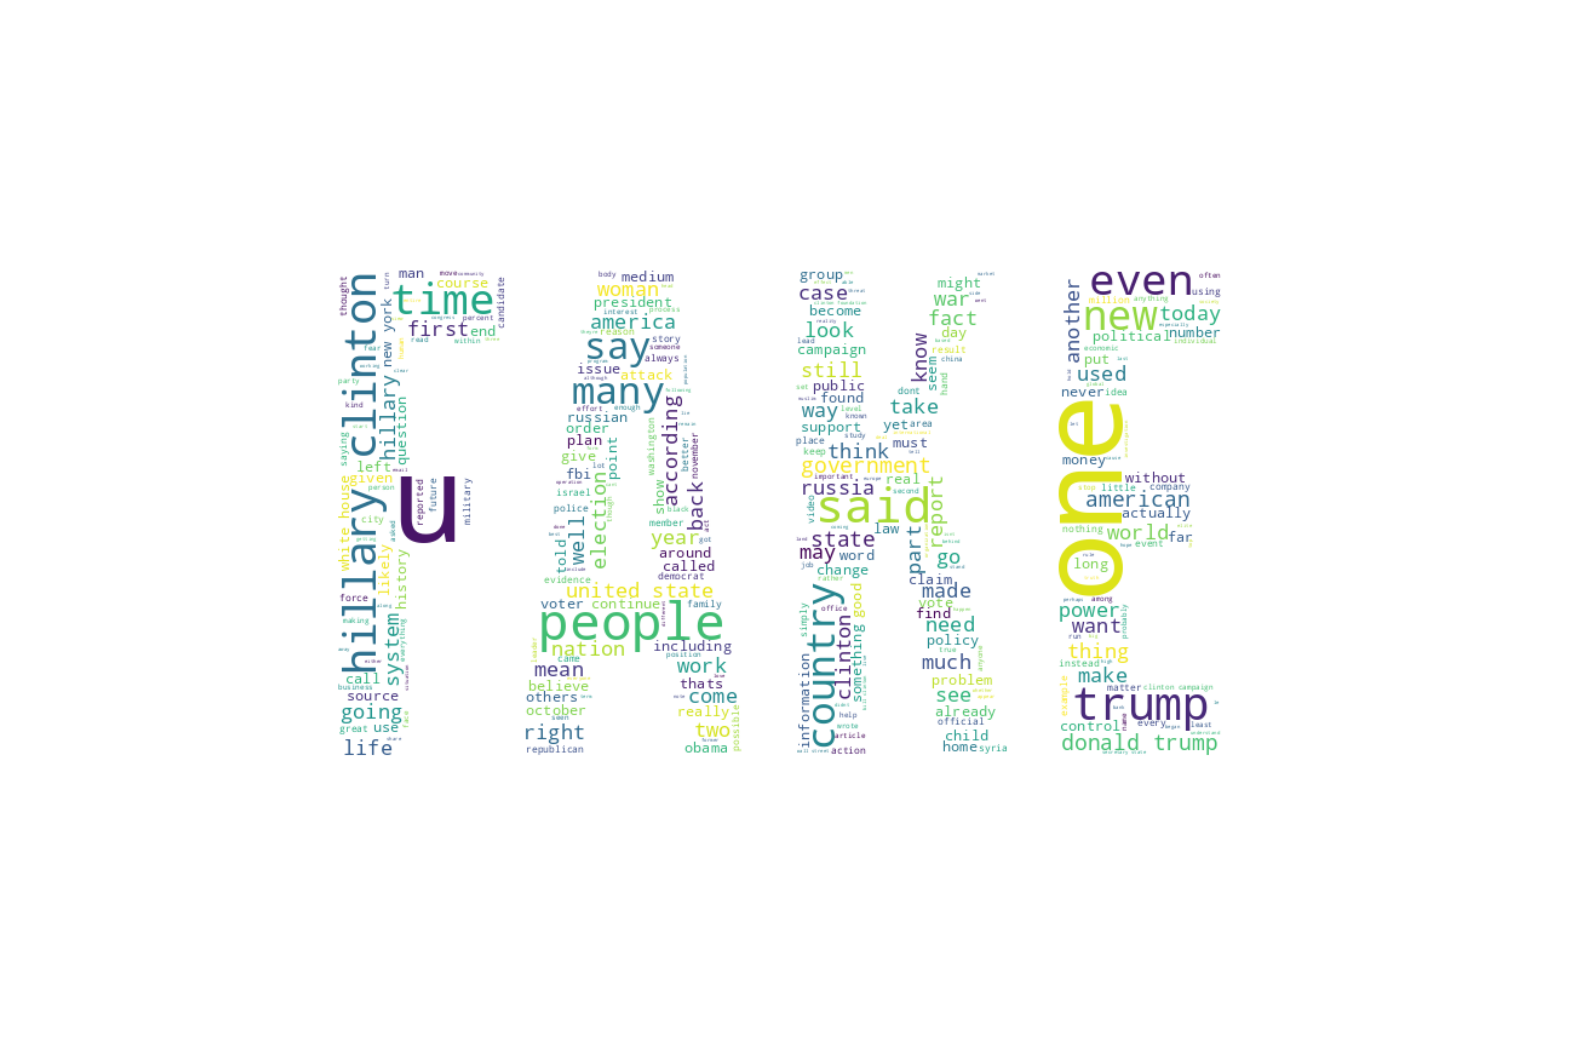

<Figure size 640x480 with 0 Axes>

In [27]:
nltk.download('wordnet')
plt.figure(figsize = (20,20))
def clean(text: str) -> list:
  'A simple function to cleanup text data'
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  text = (text.encode('ascii', 'ignore')
           .decode('utf-8', 'ignore')
           .lower())
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

corpus = clean(' '.join(df[df.label == 0].text))

def listToString(s):
  str1 = " "
  return (str1.join(s))

corpus_str = listToString(corpus)
#d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
def transform_format(val):
  if val.any() == 0:
    return 255
  else:
    return val

#coloring = np.array(Image.open(path.join(d, "/content/gdrive/MyDrive/Daco_115064.png")))
coloring = np.array(Image.open("/content/tumblr_mkfgk4gtzO1qajmbto1_1280.jpg"))

stoplist = set(STOPWORDS)
wc = WordCloud(background_color = "white", max_words = 2000, width = 1600, height = 800,mask = coloring, stopwords = stoplist, max_font_size = 100)

wc.generate(corpus_str)

image_colors = ImageColorGenerator(coloring)
plt.imshow(wc, interpolation = 'bilinear')
plt.axis("off")

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig("real_new_word_cloud.png", bbox_inches = 'tight', dpi = 600)



## 4.**Modele**

In [28]:
# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'], df['label'], test_size=0.3, random_state=42)


In [29]:
# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [30]:
# convertit un texte brut en un ensemble de tokens numériques en ajoutant des informations complémentaires comme les masques d'attention.
def tokenize_data(text, tokenizer, max_len=128):
    return tokenizer.batch_encode_plus(
        text.tolist(),
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )


In [31]:
train_encodings = tokenize_data(train_texts, tokenizer)
val_encodings = tokenize_data(val_texts, tokenizer)

In [32]:

# Data loaders
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(train_labels.values))
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], torch.tensor(val_labels.values))


In [33]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [34]:
# Define model
class BertCNN(nn.Module):
    def __init__(self, bert_model, num_classes, num_filters, filter_sizes):
        super(BertCNN, self).__init__()
        self.bert = bert_model
        self.convs = nn.ModuleList(
            [nn.Conv1d(self.bert.config.hidden_size, num_filters, fs) for fs in filter_sizes]
        )
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(num_filters * len(filter_sizes), num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state.transpose(1, 2)  # Shape: [batch_size, hidden_size, seq_length]
        x = [torch.relu(conv(last_hidden_state)).max(dim=2)[0] for conv in self.convs]
        x = torch.cat(x, dim=1)
        x = self.dropout(x)
        logits = self.fc(x)
        return logits


In [35]:

# Prepare the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertCNN(BertModel.from_pretrained('bert-base-uncased'), num_classes=2, num_filters=4, filter_sizes=[2, 3, 4, 5]).to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [36]:
# Optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
weights = torch.tensor(class_weights, dtype=torch.float).to(device)
loss_fn = nn.CrossEntropyLoss(weight=weights)


In [37]:
weights

tensor([1.0096, 0.9906])

In [38]:
# Training  Functions
def train(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss, total_acc = 0, 0
    progress_bar = tqdm(loader, desc="Training")
    for input_ids, attention_mask, labels in progress_bar:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += acc.item()
        progress_bar.set_postfix(loss=loss.item(), accuracy=acc.item())
    return total_loss / len(loader), total_acc / len(loader)


In [39]:
 # Evaluation Functions
def evaluate(model, loader, loss_fn, device):
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for input_ids, attention_mask, labels in loader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            acc = (outputs.argmax(dim=1) == labels).float().mean()
            total_loss += loss.item()
            total_acc += acc.item()
    return total_loss / len(loader), total_acc / len(loader)

In [40]:
# Run Training
for epoch in range(3):
    print(f"Epoch {epoch+1}")
    train_loss, train_acc = train(model, train_loader, optimizer, loss_fn, device)
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")



Epoch 1


Training: 100%|██████████| 278/278 [1:24:00<00:00, 18.13s/it, accuracy=0.5, loss=0.694]


Train Loss: 0.7008, Train Acc: 0.4960
Epoch 2


Training: 100%|██████████| 278/278 [1:25:06<00:00, 18.37s/it, accuracy=0, loss=0.713]


Train Loss: 0.6940, Train Acc: 0.4937
Epoch 3


Training: 100%|██████████| 278/278 [1:30:22<00:00, 19.51s/it, accuracy=1, loss=0.692]

Train Loss: 0.6932, Train Acc: 0.4969


In [ ]:
# Run Validation
for epoch in range(3):
    print(f"Epoch {epoch+1}")
    val_loss, val_acc = evaluate(model, val_loader, loss_fn, device)
    print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")

Epoch 1
Validation Loss: 0.6931, Validation Acc: 0.5095
Epoch 2
Validation Loss: 0.6931, Validation Acc: 0.5095
Epoch 3
